In [ ]:
import gymnasium as gym
import numpy as np
import torch
from utils import *
from dreamer import *
import random
torch.set_printoptions(threshold=2000, linewidth=200, sci_mode=False)
np.set_printoptions(threshold=2000, linewidth=200)

environmentName = "CarRacing-v3"
renderMode = None
numUpdates = 10000
episodesBeforeStart = 20
playInterval = 10
stepCountLimit = 256
bufferSize = 20
resume = False
saveMetrics = True
saveCheckpoints = True
runName = f"{environmentName}_BATCH_TEST_2"
checkpointToLoad = f"checkpoints/{runName}_5500"
metricsFilename = f"metrics/{runName}"
plotFilename = f"plots/{runName}"
videoFilename = f"videos/{runName}"
saveMetricsInterval = 10
checkpointInterval = 500
numNewEpisodePlay = 1
seed = 1

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make(environmentName, render_mode=renderMode)
observationShape = torch.tensor(env.observation_space.shape)
actionSize = torch.tensor(env.action_space.shape) if hasattr(env.action_space, 'shape') else np.array([env.action_space.n])
print(f"Env {environmentName} with observations {observationShape} and actions {actionSize}\n###\n")
dreamer = Dreamer()

episodeBuffer = EpisodeBuffer(size=bufferSize)

if resume:
    dreamer.loadCheckpoint(checkpointToLoad)
    start = dreamer.totalUpdates
else:
    start = 0

for i in range(start - episodesBeforeStart, start + numUpdates + 1):
    for _ in range(numNewEpisodePlay):
        if i % playInterval == 0 or i < start:
            observation, info = env.reset(seed=seed + abs(i))
            observation = torch.from_numpy(np.transpose(observation, (2, 0, 1))).unsqueeze(0).to(device).float()/255.0
            observations, actions, rewards, dones = [observation], [], [], []
            stepCount, totalReward, done = 1, 0, False
            while not done:
                action = dreamer.act(observation, reset=(stepCount == 1)).view(-1)
                observation, reward, terminated, truncated, info = env.step(action.cpu().numpy())
                observation = torch.from_numpy(np.transpose(observation, (2, 0, 1))).unsqueeze(0).to(device).float()/255.0
                stepCount += 1
                done = terminated or truncated or stepCount >= stepCountLimit
                totalReward += reward
                
                observations.append(observation)
                actions.append(action)
                rewards.append(reward)
                # dones.append(done)

            episodeBuffer.addEpisode(torch.stack(observations).squeeze(1),
                                    torch.stack(actions).to(device),
                                    torch.tensor(rewards).to(device))

    if i > start:
        selectedEpisodeObservations, selectedEpisodeActions, selectedEpisodeRewards = episodeBuffer.sampleEpisodes(dreamer.worldModelBatchSize)
        sampledFullStates, worldModelLoss, reconstructionLoss, rewardPredictionLoss, klLoss = dreamer.trainWorldModel(selectedEpisodeObservations, selectedEpisodeActions, selectedEpisodeRewards)
        criticLoss, actorLoss, valueEstimate = dreamer.trainActorCritic(sampledFullStates)

    if i % saveMetricsInterval == 0 and i > start and saveMetrics:
        saveLossesToCSV(metricsFilename, {
            "i": i,
            "worldModelLoss": worldModelLoss,
            "reconstructionLoss": reconstructionLoss,
            "rewardPredictionLoss": rewardPredictionLoss,
            "klLoss": klLoss,
            "criticLoss": criticLoss,
            "actorLoss": actorLoss,
            "valueEstimate": valueEstimate,
            "totalReward": totalReward})
        
        # print(f"\nnewest actions:\n{episodeBuffer.getNewestEpisode()[1][:5]}")

    if i % checkpointInterval == 0 and i > start and saveCheckpoints:
        print(f"i {i:6}: worldModelLoss, criticLoss, actorLoss, reward = {worldModelLoss:8.4f}, {criticLoss:8.4f}, {actorLoss:8.4f}, {totalReward:.2f}")
        dreamer.totalUpdates = i
        dreamer.saveCheckpoint(f"checkpoints/{runName}_{i}")
        plotMetrics(metricsFilename, show=False, save=True, savePath=f"{plotFilename}_{i}") # TODO: plot should replace the unnecessary previous file
        saveVideoFromGymEnv(dreamer, environmentName, f"{videoFilename}_{i}", frameLimit=stepCountLimit)

env.close()

Env CarRacing-v3 with observations tensor([96, 96,  3]) and actions tensor([3])
###

i    500: worldModelLoss, criticLoss, actorLoss, reward =   1.2315,   0.0157,   3.4734, -3.62
Saved html plot to plots/CarRacing-v3_BATCH_TEST_2_500.html
Saved video to videos/CarRacing-v3_BATCH_TEST_2_500_reward_0.mp4
i   1000: worldModelLoss, criticLoss, actorLoss, reward =   1.1784,   0.0151,   5.3605, -6.27
Saved html plot to plots/CarRacing-v3_BATCH_TEST_2_1000.html
Saved video to videos/CarRacing-v3_BATCH_TEST_2_1000_reward_-4.mp4
i   1500: worldModelLoss, criticLoss, actorLoss, reward =   1.1690,   0.0188,   0.5228, -1.19
Saved html plot to plots/CarRacing-v3_BATCH_TEST_2_1500.html
Saved video to videos/CarRacing-v3_BATCH_TEST_2_1500_reward_-4.mp4


In [2]:
for name, param in dreamer.actor.named_parameters():
    print(f"Name: {name}")
    print(f"Shape: {param.shape}")
    print(f"Values: {param.data}\n")

Name: mean.0.weight
Shape: torch.Size([256, 768])
Values: tensor([[    -0.0331,      0.0012,     -0.0354,  ...,      0.0315,      0.0322,     -0.0177],
        [     0.0145,     -0.0210,     -0.0288,  ...,      0.0133,     -0.0062,      0.0270],
        [     0.0224,     -0.0248,     -0.0294,  ...,      0.0235,     -0.0116,     -0.0091],
        ...,
        [     0.0067,     -0.0067,      0.0121,  ...,      0.0245,     -0.0059,      0.0135],
        [    -0.0284,     -0.0181,     -0.0026,  ...,      0.0047,      0.0190,      0.0314],
        [     0.0293,      0.0203,      0.0200,  ...,      0.0203,      0.0153,      0.0000]], device='cuda:0')

Name: mean.0.bias
Shape: torch.Size([256])
Values: tensor([     0.0297,      0.0252,     -0.0018,      0.0204,      0.0206,     -0.0297,     -0.0096,      0.0294,     -0.0308,     -0.0157,     -0.0057,     -0.0061,     -0.0188,     -0.0122,
            -0.0313,     -0.0185,      0.0112,      0.0270,      0.0078,     -0.0238,      0.0156,     -0

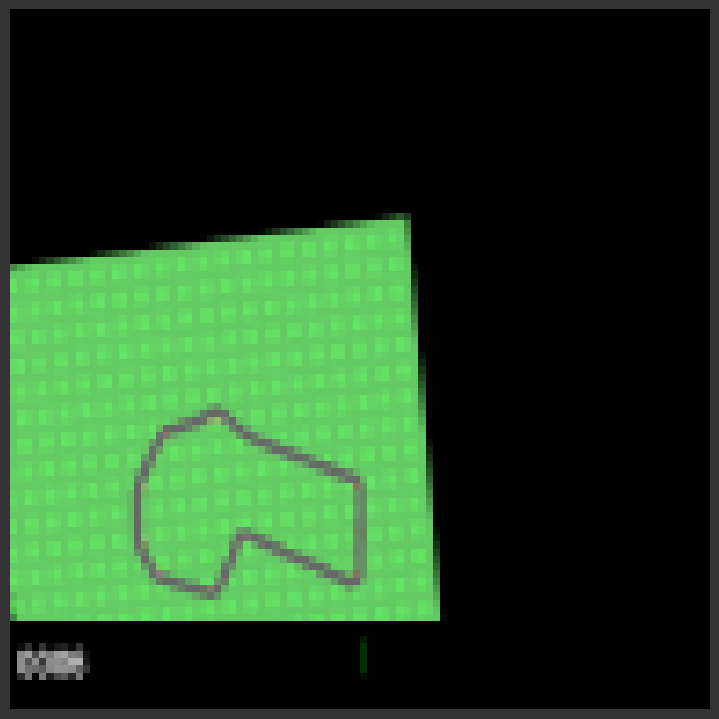

In [3]:
# Try out rollout of the world model
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

# Initialize your Dreamer model and device here
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the start image
start_image = np.array(Image.open("startImage2.png"))  # Replace with uploaded image path
start_image_tensor = torch.from_numpy(np.transpose(start_image, (2, 0, 1))).unsqueeze(0).to(device).float() / 255.0

# Initialize the rollout
recurrent_state, latent_state = dreamer.rolloutInitialize(start_image_tensor)

# Define dark mode colors
BG_COLOR = "#333333"
FG_COLOR = "#DDDDDD"
SLIDER_COLOR = "#555555"
SLIDER_THUMB_COLOR = "#AAAAAA"
BUTTON_COLOR = "#444444"
BUTTON_HOVER_COLOR = "#666666"

# GUI setup
root = tk.Tk()
root.title("Dreamer Rollout Interface")
root.configure(bg=BG_COLOR)
root.attributes('-fullscreen', True)  # Fullscreen mode
root.bind("<Escape>", lambda event: root.attributes("-fullscreen", False))  # Exit fullscreen with ESC

# Position window on primary monitor (top left corner)
root.geometry(f"{root.winfo_screenwidth()}x{root.winfo_screenheight()}+0+0")

# Styling configuration
style = ttk.Style()
style.theme_use('clam')
style.configure("TFrame", background=BG_COLOR)
style.configure("TLabel", background=BG_COLOR, foreground=FG_COLOR)
style.configure("TButton", background=BUTTON_COLOR, foreground=FG_COLOR, font=("Arial", 12), relief="flat", padding=8)
style.map("TButton", background=[("active", BUTTON_HOVER_COLOR)])

# Display for rollout images
fig, ax = plt.subplots(figsize=(7, 7))
fig.patch.set_facecolor(BG_COLOR)
ax.set_facecolor(BG_COLOR)
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True, pady=(20, 10))

def update_observation_image(obs_image):
    ax.clear()
    ax.imshow(obs_image)
    ax.axis('off')
    canvas.draw()

# Frame for sliders positioned to the right and centered below the image
slider_frame = ttk.Frame(root)
slider_frame.pack(side=tk.TOP, pady=10)

action_labels = ["Steer", "Acceleration", "Brake"]
action_ranges = [(-1, 1), (0, 1), (0, 1)]
action = torch.tensor([0.0, 1.0, 0.0], dtype=torch.float32, device=device)
sliders = []

# Spacer to push sliders to the right
spacer = ttk.Frame(slider_frame, width=200, style="TFrame")
spacer.pack(side=tk.LEFT)

# Action sliders with custom ranges and names
for i in range(3):
    label = ttk.Label(slider_frame, text=action_labels[i], font=("Arial", 12, "bold"))
    label.pack(side=tk.LEFT, padx=(20, 10))

    slider = tk.Scale(slider_frame, from_=action_ranges[i][0], to=action_ranges[i][1], resolution=0.01, orient=tk.HORIZONTAL,
                      length=300, bg=BG_COLOR, fg=FG_COLOR, troughcolor=SLIDER_COLOR, sliderrelief="flat",
                      highlightthickness=0, activebackground=SLIDER_THUMB_COLOR)
    slider.set(action[i].item())
    slider.pack(side=tk.LEFT, padx=(0, 20))
    sliders.append(slider)

# Step function
def step():
    global recurrent_state, latent_state, action
    action_values = [slider.get() for slider in sliders]
    action = torch.tensor(action_values, dtype=torch.float32, device=device)
    
    # Rollout step
    next_recurrent_state, next_latent_state, next_observation, next_reward = dreamer.rolloutStep(
        recurrent_state, latent_state, action
    )
    recurrent_state, latent_state = next_recurrent_state, next_latent_state

    # Convert observation to image and display
    obs_image = next_observation.squeeze().permute(1, 2, 0).cpu().numpy()
    obs_image = np.clip(obs_image * 255, 0, 255).astype(np.uint8)
    update_observation_image(obs_image)

# Close (X) button in the top right corner
close_button = ttk.Button(root, text="X", command=root.destroy, style="TButton")
close_button.place(relx=0.98, rely=0.02, anchor="ne")  # Position in top-right corner

# Step button below sliders
step_button = ttk.Button(root, text="Step", command=step, style="TButton")
step_button.pack(side=tk.TOP, pady=20)

# Initial display
update_observation_image(start_image)

# Run GUI
root.mainloop()


In [4]:

original = selectedEpisodeObservations[0][1:].cpu()
reconstructed = dreamer.reconstructObservations(selectedEpisodeObservations[0], selectedEpisodeActions[0]).cpu()
sideBySide = F.interpolate(torch.cat([original, reconstructed], dim=-1), size=(512, 1024), mode='bilinear')
saveVideoFrom4DTensor(sideBySide, f"results/sideBySideRepresentation_{runName}.mp4", fps=30)

In [5]:
selectedEpisodeObservations[0].shape, selectedEpisodeActions[0].shape

(torch.Size([256, 3, 96, 96]), torch.Size([255, 3]))